## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 50.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=03fd0307839b4007ce8e6a320507cb83161d7313fdad783b5c2a2049bde0e2a1
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 5.3 MB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 

The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

--2022-03-06 23:49:29--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.216.186.19
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.216.186.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-06 23:49:29 (128 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-06 23:49:29--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.216.186.19
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.216.186.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [application/json]
Saving to: ‘us-congress-tweets/tweets-sampl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050").set("spark.driver.memory", "2g").set("spark.executor.memory", "8g")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [6]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [7]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

In [ ]:
tweets.head()

Row(text='RT @maddow: "I hear a lot about about lack of corroboration. You know, you don\'t get corroboration if you don\'t talk to corroborating witne…', id=1047999818038050816, in_reply_to_user_id=None, in_reply_to_status_id=None, created_at=datetime.datetime(2018, 10, 5, 0, 0, 2), user=Row(created_at=datetime.datetime(2017, 3, 22, 3, 11, 54), followers_count=527, id=844386122822119424, name='Quazy', screen_name='quazy101'), entities=Row(hashtags=[], user_mentions=[Row(id=16129920, screen_name='maddow')]), retweeted_status=Row(id=1047941326975766530, in_reply_to_user_id=None, in_reply_to_status_id=None, created_at=datetime.datetime(2018, 10, 4, 20, 7, 36), user=Row(created_at=datetime.datetime(2008, 9, 4, 15, 2, 12), followers_count=9503143, id=16129920, name='Rachel Maddow MSNBC', screen_name='maddow')), user_id=844386122822119424)

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [52]:
# your code here for unique users
mentions_df = tweets.select(tweets.id, F.explode(tweets.entities.user_mentions))\
          .withColumnRenamed('id', 'tweet_id').select('tweet_id', F.col("col.*")).distinct()
tweets.select('user.id')\
.union(mentions_df.select('id'))\
.union(tweets.select('in_reply_to_user_id'))\
.union(tweets.select('retweeted_status.user.id'))\
.union(tweets.select('retweeted_status.in_reply_to_user_id'))\
.union(congress_members.select('userid'))\
.distinct().count()

258929

b) How many times is the user **GOPLeader** mentioned?


In [ ]:
# code here
count = mentions_df.filter(mentions_df.screen_name == 'GOPLeader').count()
print('GOPLeader was mentioned {} times'.format(count))

GOPLeader was mentioned 4728 times



c) Now find the top-5 most mentioned members of Congress.

In [ ]:
top_5_congress = mentions_df.join(congress_members, congress_members.userid == mentions_df.id, "inner")\
.groupBy('id').count()
top_5_congress_names = top_5_congress.join(congress_members, congress_members.userid == top_5_congress.id)\
.orderBy(F.col('count').desc()).limit(5)
print("Top 5 mentioned congress members")
print()
for row in top_5_congress_names.rdd.toLocalIterator():
    print("{} was mentioned {} times".format(row[3], row[1]))

Top 5 mentioned congress members

NancyPelosi was mentioned 16006 times
senatemajldr was mentioned 14903 times
LindseyGrahamSC was mentioned 14251 times
SenSchumer was mentioned 13636 times
RepAdamSchiff was mentioned 13183 times


d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [ ]:
months = {1: 'January 2019', 2: 'February 2019', 3: 'March 2019', 4: 'April 2019', 5: 'May 2019', 6: 'June 2019',
          7: 'July 2019', 8: 'August 2019', 9: 'September 2019', 10: 'October 2018', 11: 'Novemeber 2018', 12: 'December 2018'}

tweets_month = dict()
mentions_month = dict()

for i in months.keys():
  print("Top 5 mentioned users in {}".format(months[i]))
  print()
  tweets_month[i] = tweets.filter(F.month(tweets.created_at) == i)
  mentions_month[i] = tweets_month[i].select(tweets.id, F.explode(tweets.entities.user_mentions))\
          .withColumnRenamed('id', 'tweet_id').select('tweet_id', F.col("col.*")).distinct()

  user_screen_map = mentions_month[i].dropDuplicates(['id'])

  top_5 = mentions_month[i].groupBy('id').count()
  top_5_names = top_5.join(user_screen_map, user_screen_map.id == top_5.id)\
            .orderBy(F.col('count').desc()).limit(5)
 
  for row in top_5_names.rdd.toLocalIterator():
    print("{} was mentioned {} times".format(row[4], row[1]))
                    
  print()
  print()

Top 5 mentioned users in January 2019

realDonaldTrump was mentioned 4113 times
SpeakerPelosi was mentioned 3741 times
SenSchumer was mentioned 2781 times
senatemajldr was mentioned 2557 times
LindseyGrahamSC was mentioned 1797 times


Top 5 mentioned users in February 2019

marcorubio was mentioned 1872 times
realDonaldTrump was mentioned 1795 times
RepAdamSchiff was mentioned 1167 times
SpeakerPelosi was mentioned 1135 times
SenSanders was mentioned 1078 times


Top 5 mentioned users in March 2019

RepAdamSchiff was mentioned 2269 times
realDonaldTrump was mentioned 1893 times
LindseyGrahamSC was mentioned 1551 times
marcorubio was mentioned 1474 times
SpeakerPelosi was mentioned 1114 times


Top 5 mentioned users in April 2019

RepAdamSchiff was mentioned 1832 times
realDonaldTrump was mentioned 1397 times
SpeakerPelosi was mentioned 1196 times
SenSchumer was mentioned 963 times
RepJerryNadler was mentioned 920 times


Top 5 mentioned users in May 2019

LindseyGrahamSC was mentioned

e) Do you notice anything interesting in your monthly analysis?

- Top mentioned users are still congress members with the exception of president, since these tweets are mostly from political dataset.

- The president's handle **'realDonaldTrump'** (at the time of dataset) trumps all the mentioned members in most of the month.

- It could be because people put most of the political issues to president rather than congress members.

- or, since the president's handle was highly active around the 4 year tenure, there is higher chances of getting noticed and retweeted.

## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [6]:
# your network construction code here
from graphframes import *
edges = spark.read.csv("us-congress-tweets/user_mentions.csv", header=True).repartition(12).persist()
vertices = edges.select('src').union(edges.select('dst')).withColumnRenamed('src', 'id').distinct()
g = GraphFrame(vertices, edges)

How many vertices are there in your network? And how many edges?

In [ ]:
print("no of vertices = {}".format(g.vertices.count()))
print()
print("no of edges = {}".format(g.edges.count()))

no of vertices = 1133350

no of edges = 2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [ ]:
# your PageRank code here (should be pretty short since you're just calling a function)
results = g.pageRank(resetProbability=0.15, maxIter=50)

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [ ]:
# Top 10 accounts

#25073877 => Error: Not Found
#240393970 => @RepJeffDuncan
#15764644 => @SpeakerPelosi
#1249982359 => @LeaderMcConnell
#822215679726100480 => @POTUS45
#29442313 => @SenSanders
#15745368 => @marcorubio
#242555999 => @SenWhitehouse
#17494010 => @SenSchumer
#242426145 => @RepMcGovern

print("top 10 users based on the pagerank\n")
results.vertices.orderBy(F.col('pagerank').desc()).limit(10).select('id').show()

top 10 users based on the pagerank

+------------------+
|                id|
+------------------+
|          25073877|
|         240393970|
|          15764644|
|        1249982359|
|822215679726100480|
|          29442313|
|          15745368|
|         242555999|
|          17494010|
|         242426145|
+------------------+



What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

This datset is from **Oct 2018 - Sept 2019**. These tweets represent some of the most important events around that time.

- Top-10 users are mostly congress members with the exception of accounts of president. 
- The results of Top-10 users stay same and does not change with maxIter=20 iteration to 50. 
- At the top of the list is (id #25073877 which is the deleted account of Donald J. Trump (@realDonaldTrump). This account has been permanently deleted because of constant misrepresentation of the facts.
- Around Feb 2019 time **Senator Bernie Sanders(@SenSanders)** announced his presidential campaign.
- One of interesting twitter handle at **maxIter=5** is **@CelebrateMemphs**, which was created to celebrate city of Memphis's 200 year anniversary.
- **Senator Mitch McConell(@LeaderMcConnell)** and **Senator Chuck Schumer(@SenSchumer)**
were the Senate majority and minority leader respectively around that time.
- **Rep Nancy Pelosi(@SpeakerPelosi)** was the speaker of the house at that time.
- **@POTUS45** was the twitter handle of 45th President of United States(Donald J. Trump)
- I'm not sure why @senWhitehouse appears here. It might be a misnomer for people looking for accounts for whitehouse gov or he is a popular senator from Rhode Island. 
- As Chairman, **Rep Jim McGovern(@RepMcGovern)** played a central role in devising procedures adopted by the House for the Impeachment of Donald Trump.

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


In [43]:
hashtags = tweets.select('id', tweets.user.id.alias('userid'), F.explode(tweets.entities.hashtags))\
.select('id', 'userid', F.col("col.*")).withColumnRenamed('text', 'hashtag')
print("Most hashtags")
hashtags.groupBy('hashtag').count().orderBy(F.col('count').desc()).show()          

Most hashtags
+-------------+-----+
|      hashtag|count|
+-------------+-----+
|    Venezuela| 1224|
|  MoscowMitch| 1123|
|TrumpShutdown|  705|
|         MAGA|  535|
|MuellerReport|  396|
|  NancyPelosi|  349|
| MaduroRegime|  347|
|        Trump|  338|
| BuildTheWall|  333|
| GreenNewDeal|  297|
|    Kavanaugh|  292|
|     BREAKING|  277|
| ForThePeople|  224|
|       Maduro|  224|
|    Democrats|  194|
| DoWhatWeSaid|  179|
|      Mueller|  174|
|         SOTU|  173|
|          GOP|  171|
|          HR1|  168|
+-------------+-----+
only showing top 20 rows



- **Motivation**: What kind of news topic was most popular around the time. -

- I have investigated hashtags in tweets here. From the results of hastags used, we can find most discussed topics.

- **Analysis**: 
  - There is lot of discussion around **Mueller Report** which came in March 2019. This has a lot of significance since it deals with political climate at that time, and an in-depth investigation into Russian efforts to interfere in the 2016 United States presidential election, allegations of conspiracy or coordination between **Donald Trump's** presidential campaign and Russia.
  - there are also a lot of tweets discussing **The Venezuelan presidential crisis** which was an ongoing political crisis concerning the leadership and the legitimate president of **Venezuela** which has been contested since 10 January 2019, with the nation and the world divided in support for Nicolás Maduro or Juan Guaidó.  
  - Some of the top hashtags in this list is related to **Supreme Court Nominee Brett Kavanaugh hearing**.
  - #DoWhatWeSaid was one of the most trending tweets around the time, and related to Trump's Border plan.

In [56]:
tweets.groupBy('user.id').count().orderBy(F.col('count').desc()).show()

+-------------------+------+
|                 id| count|
+-------------------+------+
|               null|108015|
| 938533034659168256|   237|
|         4521330855|   115|
| 825359465826353153|   101|
| 810609636529373189|    74|
|         1151379468|    72|
|         4715692053|    57|
|         1566650000|    49|
|         1199085984|    45|
|           27124758|    44|
| 845783120716558336|    44|
|         2732784567|    43|
|          190890578|    39|
|         3280419312|    38|
| 780537959338487812|    38|
|           24470087|    37|
| 866073522036191232|    37|
|           23345560|    36|
|1021192197914464257|    36|
| 857936728165896204|    36|
+-------------------+------+
only showing top 20 rows



- About 100k almost 1/4 of total tweets are by null user which seems like users who has been deleted because of some reasons.One of these reasons being a lot of spurrious tweets. 
- A lot of these nulls might be from **deleted account of @realDonaldTrump**, but cannot be certain.
- About 200,2nd most tweets are by a bot account(@openletterbot(938533034659168256)) which publishes copies of letters to elected officials in the United States.

In [84]:
tweet_by_hour = tweets.select(F.hour('created_at').alias('hour')).groupBy('hour').count().orderBy(F.col('hour').desc())
tweet_by_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|  23|14736|
|  22|15673|
|  21|16265|
|  20|16668|
|  19|16184|
|  18|16569|
|  17|16438|
|  16|16308|
|  15|16217|
|  14|14368|
|  13|12205|
|  12|10004|
|  11| 7533|
|  10| 5158|
|   9| 3758|
|   8| 3626|
|   7| 4244|
|   6| 5352|
|   5| 7388|
|   4|10441|
|   3|13635|
|   2|15781|
|   1|16547|
|   0|16887|
+----+-----+
only showing top 24 rows



The tweets are distributed over hours. But it keeps increasing in number as the day progresses and peaks around dinner time. 

## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

**iteration 0**

h<sub>0</sub>(A) = h<sub>0</sub>(B) = h<sub>0</sub>(C) = h<sub>0</sub>(D) = h<sub>0</sub>(E) = h<sub>0</sub>(F) = h<sub>0</sub>(G) = h<sub>0</sub>(H) = 1  

a<sub>0</sub>(A) = a<sub>0</sub>(B) = a<sub>0</sub>(C) = a<sub>0</sub>(D) = a<sub>0</sub>(E) = a<sub>0</sub>(F) = a<sub>0</sub>(G) = a<sub>0</sub>(H) = 1

**iteration 1**

h<sub>1</sub>(A) = a<sub>0</sub>(B) + a<sub>0</sub>(D) = 2 \\
h<sub>1</sub>(B) = a<sub>0</sub>(D) + a<sub>0</sub>(E) = 2 \\
h<sub>1</sub>(C) = a<sub>0</sub>(D) + a<sub>0</sub>(E) = 2 \\
h<sub>1</sub>(D) = a<sub>0</sub>(F) + a<sub>0</sub>(G)= 2 \\
h<sub>1</sub>(E) = a<sub>0</sub>(C) + a<sub>0</sub>(D) + a<sub>0</sub>(G) + a<sub>0</sub>(H) = 4 \\
h<sub>1</sub>(F) = 0 \\
h<sub>1</sub>(G) = 0 \\
h<sub>1</sub>(H) = a<sub>0</sub>(C) + a<sub>0</sub>(G) = 2 \\

a<sub>1</sub>(A) = 0 \\
a<sub>1</sub>(B) = h<sub>0</sub>(A) = 1 \\
a<sub>1</sub>(C) = h<sub>0</sub>(E) + h<sub>0</sub>(H) = 2 \\
a<sub>1</sub>(D) = h<sub>0</sub>(A) + h<sub>0</sub>(B) + h<sub>0</sub>(C) + h<sub>0</sub>(E) = 4 \\
a<sub>1</sub>(E) = h<sub>0</sub>(B) + h<sub>0</sub>(C) = 2 \\
a<sub>1</sub>(F) = h<sub>0</sub>(D) = 1 \\
a<sub>1</sub>(G) = h<sub>0</sub>(D) + h<sub>0</sub>(E) + h<sub>0</sub>(H) = 3 \\
a<sub>1</sub>(H) = h<sub>0</sub>(E) = 1 \\

**iteration 2**

h<sub>2</sub>(A) = 5 \\
h<sub>2</sub>(B) = 6 \\
h<sub>2</sub>(C) = 6 \\
h<sub>2</sub>(D) = 4 \\
h<sub>2</sub>(E) = 10 \\
h<sub>2</sub>(F) = 0 \\
h<sub>2</sub>(G) = 0 \\
h<sub>2</sub>(H) = 5 \\

a<sub>2</sub>(A) = 0 \\
a<sub>2</sub>(B) = 2 \\
a<sub>2</sub>(C) = 6 \\
a<sub>2</sub>(D) = 10 \\
a<sub>2</sub>(E) = 4 \\
a<sub>2</sub>(F) = 2 \\
a<sub>2</sub>(G) = 8 \\
a<sub>2</sub>(H) = 4 \\

**iteration 3**

h<sub>3</sub>(A) = 12 \\
h<sub>3</sub>(B) = 14 \\
h<sub>3</sub>(C) = 14 \\
h<sub>3</sub>(D) = 10 \\
h<sub>3</sub>(E) = 28 \\
h<sub>3</sub>(F) = 0 \\
h<sub>3</sub>(G) = 0 \\
h<sub>3</sub>(H) = 14 \\

a<sub>3</sub>(A) = 0 \\
a<sub>3</sub>(B) = 5 \\
a<sub>3</sub>(C) = 15 \\
a<sub>3</sub>(D) = 27 \\
a<sub>3</sub>(E) = 12 \\
a<sub>3</sub>(F) = 4 \\
a<sub>3</sub>(G) = 19 \\
a<sub>3</sub>(H) = 10 \\

**iteration 4 with normalization**

h<sub>4</sub>(A) = 32/238 = 0.13 \\
h<sub>4</sub>(B) = 39/238 = 0.16 \\
h<sub>4</sub>(C) = 39/238 = 0.16 \\
h<sub>4</sub>(D) = 23/238 = 0.10 \\
h<sub>4</sub>(E) = 71/238 = 0.30  \\
h<sub>4</sub>(F) = 0/238 = 0 \\
h<sub>4</sub>(G) = 0/238 = 0 \\
h<sub>4</sub>(H) = 34/238 = 0.14 \\

a<sub>4</sub>(A) = 0/240 = 0 \\
a<sub>4</sub>(B) = 12/240 = 0.05 \\
a<sub>4</sub>(C) = 42/240 = 0.18 \\
a<sub>4</sub>(D) = 68/240 = 0.28 \\
a<sub>4</sub>(E) = 28/240 = 0.12 \\
a<sub>4</sub>(F) = 10/240 = 0.04 \\
a<sub>4</sub>(G) = 52/240 = 0.22 \\
a<sub>4</sub>(H) = 28/240 = 0.12 \\

## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


**Exercise 3.1.2**  

**A** = {1, 1, 1, 2} \\
**B** = {1, 1, 2, 2, 3} \\
**C** = {1, 2, 3, 4} \\

Jaccard similarities are:

**J(A,B)** = (A ⋂ B) / (A ⋃ B) =  3/9 = 1/3 \\
**J(B,C)** = (B ⋂ C) / (B ⋃ C) =  3/9 = 1/3 \\
**J(A,C)** = (A ⋂ C) / (A ⋃ C) =  2/8 = 1/4 \\

**Exercise 3.2.2** 

All the stopwords are word of length fewer than 3. So finding all such words in the sentence and combining with next two words, we get following shingles: \\
- The most effective
- way to represent
- to represent documents
- as sets, for
- for the purpose
- the purpose of
- of identifying lexically
- is to construct
- to construct from
- the document the
- the set of
- set of short
- of short strings


**Exercise 3.3.3** \\
**a)** \\

original matrix 

 Element |s1 | s2| s3 | s4 |
 --- |--- | --- | --- | ---|
 0 | 0 | 1 | 0 | 1
 1 | 0 | 1 | 0 | 0
 2 | 1 | 0 | 0 | 1
 3 | 0 | 0 | 1 | 0
 4 | 0 | 0 | 1 | 1
 5 | 1 | 0 | 0 | 0

 permutations matrix


 Elemenet | h1 | h2 | h3 
 --- | --- | --- | ---
 0 | 1 | 2 | 2
 1 | 3 | 5 | 1
 2 | 5 | 2 | 0
 3 | 1 | 5 | 5
 4 | 3 | 2 | 4
 5 | 5 | 5 | 3

\\
b)
**h<sub>3</sub>(x)**  is a true permutation out of 3 hash functions.

\\
c) signature matrix

 s1 | s2| s3 | s4 |
 --- | --- | --- | ---|
 5 | 1 | 1 | 1
 2 | 2 | 2 | 2
 0 | 1 | 4 | 0

\\
**Estimate jaccard probabilities**

 J<sub>e</sub>(s1,s2) = 1/3 \\
 J<sub>e</sub>(s1,s3) = 1/3 \\
 J<sub>e</sub>(s1,s4) = 2/3 \\
 J<sub>e</sub>(s2,s3) = 2/3 \\
 J<sub>e</sub>(s2,s4) = 2/3 \\
 J<sub>e</sub>(s3,s4) = 2/3 \\


**True jaccard probabilities**

 J<sub>t</sub>(s1,s2) = 0 \\
 J<sub>t</sub>(s1,s3) = 0 \\
 J<sub>t</sub>(s1,s4) = 1/4 \\
 J<sub>t</sub>(s2,s3) = 0 \\
 J<sub>t</sub>(s2,s4) = 1/4 \\
 J<sub>t</sub>(s3,s4) = 1/4 \\


**None of the estimated jaccard probabilities are close to true probabilities.**

**Exercise 3.4.1** 

**S-curve:**   $ 1 - (1-s^r)^b $

r = 3, b = 10



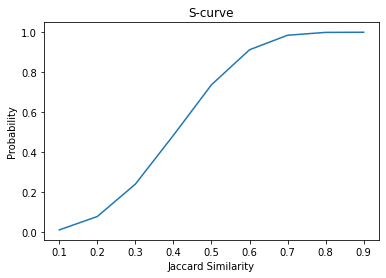


r = 6, b = 20



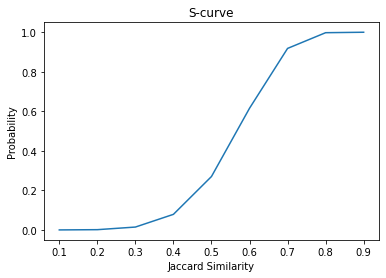


r = 5, b = 50



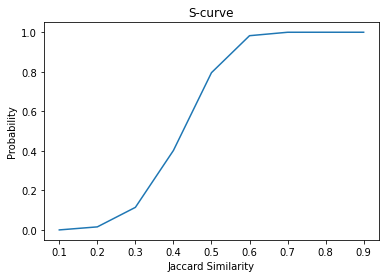

In [ ]:
import matplotlib.pyplot as plt
s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
r = [3,6,5]
b = [10,20,50]

for i in range(0,3):
  print("r = {}, b = {}\n".format(r[i],b[i]))
  values = []
  for xi in s:
    temp = pow(xi, r[i])
    p = pow(1 - temp, b[i])
    yi = 1-p
    values.append(yi)
        
  plt.plot(s, values)
  plt.xlabel("Jaccard Similarity")
  plt.ylabel("Probability")
  plt.title("S-curve")
  plt.show()

  print()
        

**Exercise 3.4.2** \\

**S-curve:**   $ 1 - (1-s^r)^b $ \\
$1/2 =  1 - (1-s^r)^b $ \\

**s** $= (1 - (1/2)^{(1/b)})^{(1/r)}$ \\

**estimate:**  $ (1/b)^{(1/r)} $

In [ ]:
r = [3,6,5]
b = [10,20,50]

for i in range(3):
    temp = 1 - pow((1/2),(1/b[i]))
    s = pow(temp,(1/r[i]))
    estimate = pow((1/b[i]),(1/r[i]))
    print('(r = {}, b = {}, s = {}, estimate = {}'.format(r[i], b[i],s,estimate))

(r = 3, b = 10, s = 0.4060881340677083, estimate = 0.4641588833612779
(r = 6, b = 20, s = 0.5693533868256982, estimate = 0.6069622310029172
(r = 5, b = 50, s = 0.4243944803687326, estimate = 0.45730505192732634
